<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Proyecto | Base de Datos de Big Data**

#### 📅 **04 de mayo de 2025**
### 👥 Equipo 29

* 🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795164 :** Oscar Andrés Ponce Parra



In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graficas import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import pandas as pd
from pyspark.ml.feature import Imputer



In [ ]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [ ]:
spark = SparkSession.builder.master("local[*]").appName("CargarCSV").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_accident = spark.read.option("header", True).option("inferSchema", True).csv(path)

In [ ]:
columnas_clave = [
    "ID", "Weather_Condition", "Severity", "Start_Time", "End_Time", "City", "State",
    "Temperature(F)", "Humidity(%)", "Visibility(mi)","Crossing","Junction","Railway",
    "Roundabout","Stop","Sunrise_Sunset","Traffic_Calming","Traffic_Signal","Turning_Loop"]

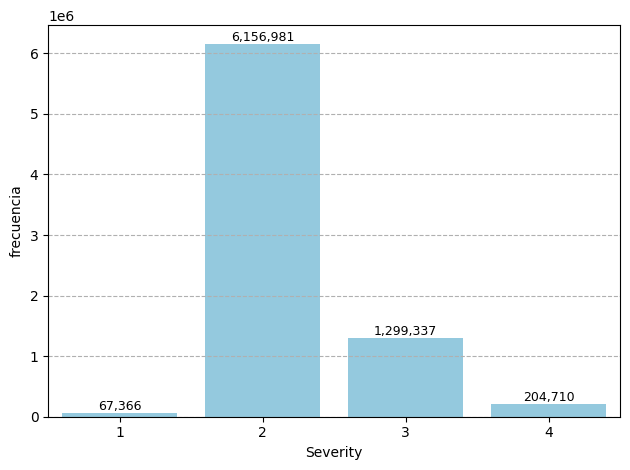

In [ ]:
barras_categorica(df_accident,'Severity')

**Obtención de las estadísticas descriptivas de las características categóricas**

# Particionamiento

El particionamiento del conjunto de datos se basa en las condiciones climáticas y la severidad del accidente, dividiéndolo en múltiples subconjuntos según combinaciones específicas de estas características.

In [ ]:
df_accident = df_accident.select(columnas_clave)

df_accident.write.mode("overwrite").partitionBy("Severity").parquet("us_accidents_partitioned")

accident_sev_1 = spark.read.parquet("us_accidents_partitioned/Severity=1")
accident_sev_2 = spark.read.parquet("us_accidents_partitioned/Severity=2")
accident_sev_3 = spark.read.parquet("us_accidents_partitioned/Severity=3")
accident_sev_4 = spark.read.parquet("us_accidents_partitioned/Severity=4")

In [ ]:
accident_sev_1.show(5)

+--------+-----------------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+------------+
|      ID|Weather_Condition|         Start_Time|           End_Time|            City|State|Temperature(F)|Humidity(%)|Visibility(mi)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|Turning_Loop|
+--------+-----------------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+------------+
|A-362864|            Clear|2017-03-19 12:08:40|2017-03-19 12:38:19|         Augusta|   GA|          57.9|       32.0|          10.0|   false|   false|  false|     false|false|           Day|          false|         false|       false|
|A-365033|    Mostly Cloudy|2017-02-19 16:21:18|2017-02-

# Imputando valores faltantes

In [ ]:
def obten_nulos(particion):

  print(f"📌 Particiones: {particion.rdd.getNumPartitions()}")
  print(f"📊 Total de filas en la partición: {particion.count()}")
  print(f"🗂️ Número de columnas en la partición: {len(particion.columns)}")

  info_nulos = {}
  cols_nulos = {}

  total_rows = particion.count()

  registros_totales = particion.count()

  # Contar valores nulos por columna

  cols_nulos = particion.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in particion.columns]
    )

  # Convertir los resultados en un diccionario
  info_nulos = {c: cols_nulos.select(c).collect()[0][0] for c in particion.columns}

  # Filtrar solo las columnas con valores nulos
  cols_nulos = {c: {"count": v, "percent": (v / total_rows) * 100} for c, v in info_nulos.items() if v > 0}

  # Validar si existen nulos
  if not cols_nulos:
        print("✅ No existen valores nulos en la partición.")
        return


  df_resumen_nulos = spark.createDataFrame(
    [(c, d["count"], round(d["percent"], 2)) for c, d in cols_nulos.items()],
    ["Columna", "Total de nulos", "%"]
  )

  df_resumen_nulos.orderBy(col("Total de nulos").desc()).show(truncate=False)


In [ ]:
def imputacion_valores(particion):


  print("✅ Se realiza la imputación utilizando los siguientes valores:\n")

  moda_Weather = particion.groupBy("Weather_Condition").count().orderBy(col("count").desc()).first()["Weather_Condition"]
  moda_City = particion.groupBy("City").count().orderBy(col("count").desc()).first()["City"]
  moda_Sunset = particion.groupBy("State").count().orderBy(col("count").desc()).first()["State"]

  media_Temperature = particion.select(avg("Temperature(F)")).collect()
  media_Humidity = particion.select(avg("Humidity(%)")).collect()
  media_Visibility = particion.select(avg("Visibility(mi)")).collect()

  print(f"🌡️ Temperatura promedio: {round(media_Temperature[0][0], 2)}")
  print(f"💧 Humedad promedio: {round(media_Humidity[0][0], 2)}")
  print(f"👀 Visibilidad promedio: {round(media_Visibility[0][0], 2)}")

  print(f"☁️ Condición meteorológica más frecuente: {moda_Weather}")
  print(f"🏙️ Ciudad más frecuente: {moda_City}")
  print(f"🌅 Hora de atardecer más frecuente: {moda_Sunset}")

  imputer_num = Imputer(
    inputCols=["Temperature(F)", "Humidity(%)", "Visibility(mi)"],
    outputCols=["Temperature(F)", "Humidity(%)", "Visibility(mi)"]
  ).setStrategy("mean")

  particion = imputer_num.fit(particion).transform(particion)
  particion = particion.na.fill({"Weather_Condition": moda_Weather, "City": moda_City, "Sunrise_Sunset": moda_Sunset})

  particion_modificada = particion

  print("\n🔍 Se validan nuevamente los valores nulos para corroborar la imputación.\n")

  obten_nulos(particion_modificada)

  return particion_modificada




In [ ]:
obten_nulos(accident_sev_1)

📌 Particiones: 13
📊 Total de filas en la partición: 67366
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Humidity(%)      |1249          |1.85|
|Temperature(F)   |1110          |1.65|
|Weather_Condition|954           |1.42|
|Visibility(mi)   |935           |1.39|
|Sunrise_Sunset   |204           |0.3 |
|City             |3             |0.0 |
+-----------------+--------------+----+



In [ ]:
imp_sev_1 = imputacion_valores(accident_sev_1)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 72.42
💧 Humedad promedio: 61.91
👀 Visibilidad promedio: 9.48
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Tucson
🌅 Hora de atardecer más frecuente: CA

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 13
📊 Total de filas en la partición: 67366
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


In [ ]:
obten_nulos(accident_sev_2)

📌 Particiones: 20
📊 Total de filas en la partición: 6156981
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Humidity(%)      |138627        |2.25|
|Visibility(mi)   |138237        |2.25|
|Weather_Condition|134781        |2.19|
|Temperature(F)   |130158        |2.11|
|Sunrise_Sunset   |20079         |0.33|
|City             |217           |0.0 |
+-----------------+--------------+----+



In [ ]:
imputacion_valores(accident_sev_2)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 61.55
💧 Humedad promedio: 64.67
👀 Visibilidad promedio: 9.09
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Miami
🌅 Hora de atardecer más frecuente: CA

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 20
📊 Total de filas en la partición: 6156981
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


DataFrame[ID: string, Weather_Condition: string, Start_Time: timestamp, End_Time: timestamp, City: string, State: string, Temperature(F): double, Humidity(%): double, Visibility(mi): double, Crossing: boolean, Junction: boolean, Railway: boolean, Roundabout: boolean, Stop: boolean, Sunrise_Sunset: string, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean]

In [ ]:
obten_nulos(accident_sev_3)

📌 Particiones: 13
📊 Total de filas en la partición: 1299337
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Visibility(mi)   |30511         |2.35|
|Weather_Condition|30295         |2.33|
|Humidity(%)      |27322         |2.1 |
|Temperature(F)   |25977         |2.0 |
|Sunrise_Sunset   |689           |0.05|
|City             |13            |0.0 |
+-----------------+--------------+----+



In [ ]:
imputacion_valores(accident_sev_3)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 62.2
💧 Humedad promedio: 65.38
👀 Visibilidad promedio: 9.09
☁️ Condición meteorológica más frecuente: Clear
🏙️ Ciudad más frecuente: Los Angeles
🌅 Hora de atardecer más frecuente: CA

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 13
📊 Total de filas en la partición: 1299337
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


DataFrame[ID: string, Weather_Condition: string, Start_Time: timestamp, End_Time: timestamp, City: string, State: string, Temperature(F): double, Humidity(%): double, Visibility(mi): double, Crossing: boolean, Junction: boolean, Railway: boolean, Roundabout: boolean, Stop: boolean, Sunrise_Sunset: string, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean]

In [ ]:
obten_nulos(accident_sev_4)

📌 Particiones: 12
📊 Total de filas en la partición: 204710
🗂️ Número de columnas en la partición: 18
+-----------------+--------------+----+
|Columna          |Total de nulos|%   |
+-----------------+--------------+----+
|Weather_Condition|7429          |3.63|
|Visibility(mi)   |7415          |3.62|
|Humidity(%)      |6946          |3.39|
|Temperature(F)   |6608          |3.23|
|Sunrise_Sunset   |2274          |1.11|
|City             |20            |0.01|
+-----------------+--------------+----+



In [ ]:
imputacion_valores(accident_sev_4)

✅ Se realiza la imputación utilizando los siguientes valores:

🌡️ Temperatura promedio: 58.14
💧 Humedad promedio: 67.3
👀 Visibilidad promedio: 9.06
☁️ Condición meteorológica más frecuente: Fair
🏙️ Ciudad más frecuente: Atlanta
🌅 Hora de atardecer más frecuente: VA

🔍 Se validan nuevamente los valores nulos para corroborar la imputación.

📌 Particiones: 12
📊 Total de filas en la partición: 204710
🗂️ Número de columnas en la partición: 18
✅ No existen valores nulos en la partición.


DataFrame[ID: string, Weather_Condition: string, Start_Time: timestamp, End_Time: timestamp, City: string, State: string, Temperature(F): double, Humidity(%): double, Visibility(mi): double, Crossing: boolean, Junction: boolean, Railway: boolean, Roundabout: boolean, Stop: boolean, Sunrise_Sunset: string, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean]

# Preparando datos

In [ ]:
imp_sev_1.show(5)

+--------+-----------------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+------------+
|      ID|Weather_Condition|         Start_Time|           End_Time|            City|State|Temperature(F)|Humidity(%)|Visibility(mi)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|Turning_Loop|
+--------+-----------------+-------------------+-------------------+----------------+-----+--------------+-----------+--------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+------------+
|A-362864|            Clear|2017-03-19 12:08:40|2017-03-19 12:38:19|         Augusta|   GA|          57.9|       32.0|          10.0|   false|   false|  false|     false|false|           Day|          false|         false|       false|
|A-365033|    Mostly Cloudy|2017-02-19 16:21:18|2017-02-

In [ ]:
categoricas = ["Weather_Condition", "City", "State", "Sunrise_Sunset"]
binarias = ["Crossing", "Junction", "Railway", "Roundabout", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]

In [ ]:
# ✅ Crear una copia de `imp_sev_1` para trabajar sobre ella
transf_sev_1 = imp_sev_1.alias("copia_imp_sev_1")  # Esto asegura que el original quede intacto

# Convertir variables binarias a 0 y 1 en la copia
for columna in binarias:
    transf_sev_1 = transf_sev_1.withColumn(columna + "_num", col(columna).cast("int"))

# Aplicar StringIndexer a las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index").fit(transf_sev_1) for col in categoricas]
for indexer in indexers:
    transf_sev_1 = indexer.transform(transf_sev_1)

# Aplicar One-Hot Encoding a las categóricas
codificadores = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_OHE").fit(transf_sev_1) for col in categoricas]
for codificador in codificadores:
    transf_sev_1 = codificador.transform(transf_sev_1)

# 🔥 Eliminar las columnas originales que ya no se usarán en el modelo
transf_sev_1 = transf_sev_1.drop(*categoricas).drop(*binarias)

transf_sev_1.show()




+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+----------------+-----------------------+----------+-----------+--------------------+---------------------+-------------------+---------------+------------------+
|      ID|         Start_Time|           End_Time|Temperature(F)|Humidity(%)|   Visibility(mi)|Crossing_num|Junction_num|Railway_num|Roundabout_num|Stop_num|Traffic_Calming_num|Traffic_Signal_num|Turning_Loop_num|Weather_Condition_Index|City_Index|State_Index|Sunrise_Sunset_Index|Weather_Condition_OHE|           City_OHE|      State_OHE|Sunrise_Sunset_OHE|
+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+----------------+-----------------------+----------+-----------+--------------------+-

# Creando conjuntos de datos

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", "200")

train_sev1,test_sev1 = transf_sev_1.randomSplit([0.8,0.2], seed = 10)

print(f"""Existen {train_sev1.count()} instancias en el conjunto train, y {test_sev1.count()} en el conjunto test""")

train_sev1.show(5)

Existen 53888 instancias en el conjunto train, y 13478 en el conjunto test
+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+----------------+-----------------------+----------+-----------+--------------------+---------------------+-------------------+---------------+------------------+
|      ID|         Start_Time|           End_Time|Temperature(F)|Humidity(%)|   Visibility(mi)|Crossing_num|Junction_num|Railway_num|Roundabout_num|Stop_num|Traffic_Calming_num|Traffic_Signal_num|Turning_Loop_num|Weather_Condition_Index|City_Index|State_Index|Sunrise_Sunset_Index|Weather_Condition_OHE|           City_OHE|      State_OHE|Sunrise_Sunset_OHE|
+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+-----------

In [ ]:
atributos = [ 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Crossing_num', 'Junction_num', 'Railway_num',
              'Roundabout_num', 'Stop_num', 'Traffic_Signal_num', 'Turning_Loop_num',
              'Sunrise_Sunset_Index','Weather_Condition_Index','City_Index','State_Index','Weather_Condition_OHE',
              'City_OHE','State_OHE']

In [ ]:
assembler = VectorAssembler(inputCols=atributos, outputCol = 'Attributes')
output_train = assembler.transform(train_sev1)
output_test = assembler.transform(test_sev1)

output_train.show(5)
output_test.show(5)

+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+----------------+-----------------------+----------+-----------+--------------------+---------------------+-------------------+---------------+------------------+--------------------+
|      ID|         Start_Time|           End_Time|Temperature(F)|Humidity(%)|   Visibility(mi)|Crossing_num|Junction_num|Railway_num|Roundabout_num|Stop_num|Traffic_Calming_num|Traffic_Signal_num|Turning_Loop_num|Weather_Condition_Index|City_Index|State_Index|Sunrise_Sunset_Index|Weather_Condition_OHE|           City_OHE|      State_OHE|Sunrise_Sunset_OHE|          Attributes|
+--------+-------------------+-------------------+--------------+-----------+-----------------+------------+------------+-----------+--------------+--------+-------------------+------------------+----------------+-----------------------+---

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'Attributes', labelCol = 'Traffic_Calming_num', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(output_train)

In [ ]:
print ("The coefficient of the model is : ", lr_model.coefficients)
print ("The Intercept of the model is : ", lr_model.intercept)

The coefficient of the model is :  [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
Pred_lr = lr_model.evaluate(output_test)

In [ ]:
#Root Mean Square Error
eval_lr = RegressionEvaluator(labelCol="Sunrise_Sunset_Index", predictionCol="prediction", metricName="rmse")
rmse_lr = eval_lr.evaluate(Pred_lr.predictions)
print("RMSE: %.3f" % rmse_lr)

# Mean Square Error
mse = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 0.441
MSE: 0.195
MAE: 0.189
r2: -0.218
